In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import pyslha
import ROOT

ROOT.gSystem.Load(os.path.abspath(os.path.join(os.getcwd(),"../Delphes/libDelphes.so")))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.24/06


In [2]:
parameters = pyslha.readSLHAFile('../DMSimp_monojet/Cards/param_card.dat')
mMed = parameters.blocks['MASS'][55]
mDM = parameters.blocks['MASS'][52]
gVq = parameters.blocks['DMINPUTS'][4] # Mediator-quark vector coupling
gAq = parameters.blocks['DMINPUTS'][10] # Mediator-quark axial coupling
gVx = parameters.blocks['DMINPUTS'][2] # Mediator-DM vector coupling
gAx = parameters.blocks['DMINPUTS'][3] # Mediator-DM axial coupling

In [3]:
inputFiles = {'point1' : './test.root'}
xsecsPB = {'point1' : 1.553e+02}

In [4]:
# Cuts 
## jets
pTj1min = 100.
etamax = 2.4
## MET
minMET = 250.

In [24]:
pTj1 = []
weights = []
allweights = []
met = []
njets = []
dmPT = []
cutFlow = OrderedDict({'Electron Veto' : 0, 'Muon Veto' : 0, 'pTmiss cut': 0, 'pT(j1) cut' : 0})
for label,inputFile in inputFiles.items():

    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    
    for ievt in range(nevts):    
        tree.GetEntry(ievt)        

        particles = tree.Particle
        jets = tree.Jet
#         weight = xsecsPB[label]/nevts
        weight = tree.Event.At(0).Weight
        allweights.append(weight)
        
        # Get DM particles and  jets (gen level)
        dmList = []
        jets = []
        for ip in range(particles.GetEntries()):
            p = particles.At(ip)
#             print('%3i %3i %3i %3i %3i %3i %3i' %(ip,p.PID,p.Status,p.M1,p.M2,p.D1,p.D2))
            if abs(p.PID) not in [52,1,2,3,4,5,6,21]:
                continue
            if abs(p.PID) == 52 and p.Status == 1: # final state DM
                dmList.append(p)
            elif p.M1 in [0,1] and p.M2 in [0,1]: # Hard event jets
                jets.append(p)
                
        if len(jets) == 0:
            for ip in range(particles.GetEntries()):
                p = particles.At(ip)
                print('%3i %3i %3i %3i %3i %3i %3i' %(ip,p.PID,p.Status,p.M1,p.M2,p.D1,p.D2))
            break

            
        njets.append(len(jets))                
        # Compute MET
        if len(dmList) != 2:
            print('Error: found %i DM particles in the event' %len(dmList))
            break
            
        MET = np.sqrt((dmList[0].Px + dmList[1].Px)**2 + (dmList[0].Py + dmList[1].Py)**2)
            
        # Filter jets
        jetList = []
        for jet in jets:
            if abs(jet.Eta) > etamax:
                continue
            jetList.append(jet)  
        jetList = sorted(jetList, key = lambda j: j.PT, reverse=True)                    

        # Apply cuts:
        ## Cut on MET
        if MET < minMET: continue  
        cutFlow['pTmiss cut'] += weight
        ## Veto zero jet events
        if len(jetList) < 1 or jetList[0].PT < pTj1min: continue
        cutFlow['pT(j1) cut'] += weight
        
        # Store relevant data
        pTj1.append(jetList[0].PT)
        weights.append(weight)
        met.append(MET)
        

weights = np.array(weights)
pTj1 = np.array(pTj1)
met = np.array(met)
njets = np.array(njets)

  0   2  21   8  -1   3   4
  1  21  43   8  -1  20  20
  2  21  21   9  -1   3   4
  3  55  22   0   2   7   7
  4   2  23   0   2   5   6
  5   2  51   4  -1  12  12
  6  21  51   4  -1  13  13
  7  55  52   3  -1  11  11
  8   2  41  14  -1   0   1
  9  21  42  15  -1   2   2
 10  21  43  15  -1  30  30
 11  55  44   7  -1  17  17
 12   2  44   5  -1  18  18
 13  21  44   6  -1  19  19
 14   2  42  24  -1   8   8
 15  21  41  25  -1   9  10
 16  21  43  25  -1  45  45
 17  55  44  11  -1  26  26
 18   2  44  12  -1  23  23
 19  21  44  13  -1  21  22
 20  21  44   1  -1  29  29
 21  21  51  19  -1  28  28
 22  21  51  19  -1  31  31
 23   2  52  18  -1  27  27
 24   2  42  36  -1  14  14
 25  21  41  34  -1  15  16
 26  55  44  17  -1  39  39
 27   2  44  23  -1  40  40
 28  21  44  21  -1  32  33
 29  21  44  20  -1  42  42
 30  21  44  10  -1  43  43
 31  21  44  22  -1  44  44
 32  21  51  28  -1  41  41
 33  21  51  28  -1  46  46
 34  21  53  37  -1  25  25
 35  21  43  37  -1 

In [19]:
# Print cutflow:
totalweight = sum(allweights)
for cut,weight in cutFlow.items():
    eff = weight/totalweight
    print(cut,'eff = %1.3f' %eff)

Electron Veto eff = 0.000
Muon Veto eff = 0.000
pTmiss cut eff = 0.175
pT(j1) cut eff = 0.089


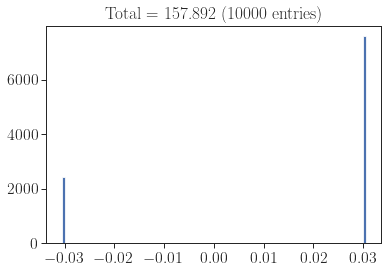

In [20]:
plt.hist(allweights,bins=100)
plt.title('Total = %1.3f (%i entries)' %(sum(allweights),len(allweights)))
plt.show()

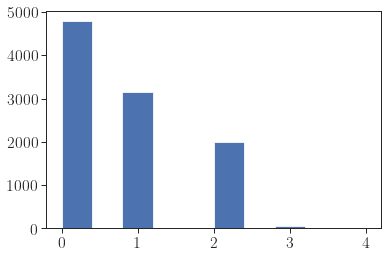

In [23]:
plt.hist(njets,bins=10)
plt.show()

In [ ]:
lum2017 = 41.5 #fb^-1
fig = plt.figure(figsize=(8,6))
plt.hist(pTj1,bins=25,weights=weights*1e3*lum2017)
plt.title(r'$\mathcal{L} = %1.1f$ fb$^{-1}$ (2017), $\epsilon$(pre) = %1.3f' %(lum2017,len(pTj1)/nevts))
plt.xlabel(r'$p_{T}(j_{1})$ (GeV)')
plt.ylabel('Events')
plt.yscale('log')
textstr = '\n'.join((
    r'$m_{med} =$ %1.0f GeV' %mMed, 
    r'$m_{DM} =$ %1.0f GeV' %mDM,
    r'$g_{q}^{V}=$ %1.2f, $g_{q}^{A}=$ %1.2f' % (gVq, gAq),
    r'$g_{\chi}^{V}=$ %1.2f, $g_{\chi}^{A}=$ %1.2f' % (gVx, gAx)))
plt.text(0.6,0.7,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)
plt.show()

In [ ]:
sum(weights[pTj1 > 250.]*1e3*lum2017)